In [95]:
# the following code lines are necessary to import custom module
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import boto3
import io
import json
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.multioutput import RegressorChain
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import HalvingGridSearchCV
from src.preprocessing.feature_engineer import get_wind_components, resample_data, feature_engineer

In [96]:
def get_timestamp(df):
    df["#HR_int"] = df["#HR"].astype(int).astype(str).str.zfill(2)
    df["date"] = pd.to_datetime(df["Year"] * 1000 + df["YD"], format="%Y%j").astype(str)
    df["datetime"] = df["date"] + " " + df["#HR_int"] + ":00:00"
    df["timestamp"] = pd.to_datetime(df["datetime"])
    df = df.drop(["#HR_int", "date", "datetime"], axis=1)
    return df

In [97]:
def statistical_test(sample_a, sample_b):
    w, pvalue_shapiro_a = stats.shapiro(sample_a)
    w, pvalue_shapiro_b = stats.shapiro(sample_b)
    threshold_shapiro = 0.05
    if (pvalue_shapiro_a > threshold_shapiro) & (pvalue_shapiro_b > threshold_shapiro):
        statistic, pvalue = stats.ttest_ind(sample_a, sample_b)
        if pvalue > 0.05:
            output = f"T-test: p-value: {pvalue}. Samples have same distribution, then not reject null hypothesis (H0)"
        else:
            output = f"T-test: p-value: {pvalue}. Samples are different, then reject null hypothesis (H0)"
    else:
        statistic, pvalue = stats.mannwhitneyu(sample_a, sample_b)
        if pvalue > 0.05:
            output = f"Mann-Whitney: p-value: {pvalue}. Samples have same distribution, then not reject null hypothesis (H0)"
        else:
            output = f"Mann-Whitney: p-value: {pvalue}. Samples are different, then reject null hypothesis (H0)"
    return (statistic, pvalue, output)

In [98]:
# AWS credentials to read files on S3 bucket
f = open('../credentials.json')
credentials = json.load(f)

s3_client = boto3.client(
    "s3",
    aws_access_key_id=credentials["Access key ID"],
    aws_secret_access_key=credentials["Secret access key"]
    )

s3_resource = boto3.resource(
    "s3",
    aws_access_key_id=credentials["Access key ID"],
    aws_secret_access_key=credentials["Secret access key"]
    )

In [99]:
# get IAG .dat data from S3 bucket
prefix_objs = s3_resource.Bucket("iag-usp").objects.filter(Prefix=f"raw/")
keys = [obj.key for obj in prefix_objs]
print(keys)

['raw/', 'raw/ITU_2017.dat', 'raw/PR40_IT_17.DAT', 'raw/SFZ_2017.dat', 'raw/SFZe_2017.dat']


In [100]:
obj = s3_client.get_object(Bucket="iag-usp", Key="raw/ITU_2017.dat")
ITU_2017 = pd.read_csv(io.BytesIO(obj["Body"].read()), sep="\s+")
ITU_2017

,#HR,YD,Year,T_CS215(C),RH_CS215(%),WS_034B(ms),WD_034B(degree),NetRL1(Wm2),Precip(mm)
0,0.000,1,2017,20.27,100.0,0.859,58.57,18.766,0.0
1,0.083,1,2017,20.33,100.0,1.034,70.04,20.074,0.0
2,0.167,1,2017,20.36,100.0,1.085,70.52,20.942,0.0
3,0.250,1,2017,20.39,100.0,1.084,69.76,21.190,0.0
4,0.333,1,2017,20.43,100.0,1.260,73.69,21.465,0.0
...,...,...,...,...,...,...,...,...,...
98781,23.250,365,2017,19.31,99.0,0.551,334.30,48.107,0.0
98782,23.333,365,2017,19.26,99.2,0.130,287.80,47.749,0.0
98783,23.417,365,2017,19.19,99.2,0.745,322.80,47.680,0.0
98784,23.500,365,2017,19.21,99.2,0.999,355.30,45.325,0.0


In [101]:
print(ITU_2017.columns)

Index(['#HR', 'YD', 'Year', 'T_CS215(C)', 'RH_CS215(%)', 'WS_034B(ms)',
       'WD_034B(degree)', 'NetRL1(Wm2)', 'Precip(mm)'],
      dtype='object')


In [102]:
ITU_2017_metadata = {
    "#HR": "hour",
    "YD": "Day of the year",
    "Year": "Year",
    "T_CS215(C)": "Air temperature in Celsius",
    "RH_CS215(%)": "Percentual relative humidity",
    "WS_034B(ms)": "Wind speed in m/s",
    "WD_034B(degree)": "Wind direction in degrees",
    "NetRL1(Wm2)": "Net radiation in Watt/m²",
    "Precip(mm)": "Precipitation in mm"
}

In [103]:
ITU_2017 = get_timestamp(df=ITU_2017)
ITU_2017

,#HR,YD,Year,T_CS215(C),RH_CS215(%),WS_034B(ms),WD_034B(degree),NetRL1(Wm2),Precip(mm),timestamp
0,0.000,1,2017,20.27,100.0,0.859,58.57,18.766,0.0,2017-01-01 00:00:00
1,0.083,1,2017,20.33,100.0,1.034,70.04,20.074,0.0,2017-01-01 00:00:00
2,0.167,1,2017,20.36,100.0,1.085,70.52,20.942,0.0,2017-01-01 00:00:00
3,0.250,1,2017,20.39,100.0,1.084,69.76,21.190,0.0,2017-01-01 00:00:00
4,0.333,1,2017,20.43,100.0,1.260,73.69,21.465,0.0,2017-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
98781,23.250,365,2017,19.31,99.0,0.551,334.30,48.107,0.0,2017-12-31 23:00:00
98782,23.333,365,2017,19.26,99.2,0.130,287.80,47.749,0.0,2017-12-31 23:00:00
98783,23.417,365,2017,19.19,99.2,0.745,322.80,47.680,0.0,2017-12-31 23:00:00
98784,23.500,365,2017,19.21,99.2,0.999,355.30,45.325,0.0,2017-12-31 23:00:00


In [104]:
ITU_2017 = ITU_2017.drop(columns=["#HR", "YD", "Year"])
ITU_2017.columns = ["Temperatura", "Umidade relativa", "wind_velocity", "wind_direction", "radiation", "precipitation", "timestamp"]
ITU_2017

,Temperatura,Umidade relativa,wind_velocity,wind_direction,radiation,precipitation,timestamp
0,20.27,100.0,0.859,58.57,18.766,0.0,2017-01-01 00:00:00
1,20.33,100.0,1.034,70.04,20.074,0.0,2017-01-01 00:00:00
2,20.36,100.0,1.085,70.52,20.942,0.0,2017-01-01 00:00:00
3,20.39,100.0,1.084,69.76,21.190,0.0,2017-01-01 00:00:00
4,20.43,100.0,1.260,73.69,21.465,0.0,2017-01-01 00:00:00
...,...,...,...,...,...,...,...
98781,19.31,99.0,0.551,334.30,48.107,0.0,2017-12-31 23:00:00
98782,19.26,99.2,0.130,287.80,47.749,0.0,2017-12-31 23:00:00
98783,19.19,99.2,0.745,322.80,47.680,0.0,2017-12-31 23:00:00
98784,19.21,99.2,0.999,355.30,45.325,0.0,2017-12-31 23:00:00


In [105]:
ITU_2017_wind = ITU_2017[["timestamp", "wind_velocity", "wind_direction"]]
ITU_2017_wind = resample_data(ITU_2017_wind).reset_index()
ITU_2017_wind.to_csv("itupeva_2017.csv", index=False, sep=",")

/home/ubuntu/ml-uhi/src/preprocessing/feature_engineer.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["timestamp"] = pd.to_datetime(df["timestamp"])


In [106]:
ITU_2017 = get_wind_components(
    df=ITU_2017, 
    wind_velocity="wind_velocity", 
    wind_direction="wind_direction", 
    x_name="Vel. do vento (zonal)", 
    y_name="Vel. do vento (meridional)"
    )

ITU_2017 = ITU_2017.drop(["wind_velocity", "wind_direction"], axis=1)
ITU_2017

,Temperatura,Umidade relativa,radiation,precipitation,timestamp,Vel. do vento (zonal),Vel. do vento (meridional)
0,20.27,100.0,18.766,0.0,2017-01-01 00:00:00,-0.732966,-0.447931
1,20.33,100.0,20.074,0.0,2017-01-01 00:00:00,-0.971889,-0.352970
2,20.36,100.0,20.942,0.0,2017-01-01 00:00:00,-1.022892,-0.361823
3,20.39,100.0,21.190,0.0,2017-01-01 00:00:00,-1.017065,-0.375013
4,20.43,100.0,21.465,0.0,2017-01-01 00:00:00,-1.209293,-0.353851
...,...,...,...,...,...,...,...
98781,19.31,99.0,48.107,0.0,2017-12-31 23:00:00,0.238946,-0.496493
98782,19.26,99.2,47.749,0.0,2017-12-31 23:00:00,0.123777,-0.039740
98783,19.19,99.2,47.680,0.0,2017-12-31 23:00:00,0.450426,-0.593415
98784,19.21,99.2,45.325,0.0,2017-12-31 23:00:00,0.081857,-0.995641


In [107]:
ITU_2017 = resample_data(ITU_2017)
ITU_2017["station"] = ""
ITU_2017["station_name"] = "Itupeva"
ITU_2017

,Temperatura,Umidade relativa,radiation,precipitation,Vel. do vento (zonal),Vel. do vento (meridional),station,station_name
timestamp,,,,,,,,
2017-01-01 00:00:00,20.287500,100.000000,23.491417,0.000000,-0.690697,-0.230463,,Itupeva
2017-01-01 01:00:00,20.059167,100.000000,32.577167,0.000000,-0.396673,-0.252110,,Itupeva
2017-01-01 02:00:00,19.351667,100.000000,32.335333,0.000000,0.162298,0.183269,,Itupeva
2017-01-01 03:00:00,19.265833,100.000000,37.048417,0.000000,-0.355938,-0.428380,,Itupeva
2017-01-01 04:00:00,19.806667,100.000000,44.944667,0.000000,-0.218308,-0.417090,,Itupeva
...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,22.016667,89.383333,32.250083,0.000000,0.452990,-2.162629,,Itupeva
2017-12-31 20:00:00,21.051667,91.800000,22.436833,0.021167,0.885748,-2.186440,,Itupeva
2017-12-31 21:00:00,19.840000,97.458333,31.770500,0.000000,0.284581,-0.865269,,Itupeva


In [108]:
obj = s3_client.get_object(Bucket="iag-usp", Key="raw/PR40_IT_17.DAT")
PR40_IT_17 = pd.read_csv(io.BytesIO(obj["Body"].read()), sep="\s+")
PR40_IT_17.head()

,0.441,930.586,10.583,44,2017,9
0,0.444,930.584,10.667,44,2017,9
1,0.448,930.568,10.750,44,2017,9
2,0.455,915.193,10.917,44,2017,9
3,0.458,930.608,11.000,44,2017,9
4,0.462,930.627,11.083,44,2017,9


In [109]:
obj = s3_client.get_object(Bucket="iag-usp", Key='raw/SFZ_2017.dat')
SFZ_2017 = pd.read_csv(io.BytesIO(obj["Body"].read()), sep="\s+")
SFZ_2017.head()

,#HR,YD,Year,T_CS215(C),RH_CS215(%),WS_034B(ms),WD_034B(degree),NetRL1(Wm2),Precip(mm),WS_CSAT(m/s),WD_CSAT(degree)
0,0.083,1,2017,23.07,81.0,3.036,12.98,39.439,0.0,3.104,28.009
1,0.167,1,2017,23.07,81.1,2.820,15.94,39.170,0.0,2.690,31.425
2,0.250,1,2017,23.08,81.1,2.382,9.84,39.085,0.0,2.543,23.273
3,0.333,1,2017,23.08,81.1,1.980,9.10,39.528,0.0,0.910,350.112
4,0.417,1,2017,23.06,81.1,1.478,11.21,40.063,0.0,2.021,21.471


In [110]:
SFZ_2017_metadata = {
    "#HR": "hour",
    "YD": "Day of the year",
    "Year": "Year",
    "T_CS215(C)": "Air temperature in Celsius",
    "RH_CS215(%)": "Percentual relative humidity",
    "WS_034B(ms)": "Wind speed in m/s",
    "WD_034B(degree)": "Wind direction in degrees",
    "NetRL1(Wm2)": "Net radiation in Watt/m²",
    "Precip(mm)": "Precipitation in mm",
    "WS_CSAT(m/s)": "Wind speed in m/s",
    "WD_CSAT(degree)": "Wind direction in degrees"
}

In [111]:
SFZ_2017 = get_timestamp(df=SFZ_2017)
SFZ_2017 = SFZ_2017.drop(["#HR", "YD", "Year", "WS_CSAT(m/s)", "WD_CSAT(degree)"], axis=1)
SFZ_2017.columns = ["Temperatura", "Umidade relativa", "wind_velocity", "wind_direction", "radiation", "precipitation", "timestamp"]

SFZ_2017_wind = SFZ_2017[["timestamp", "wind_velocity", "wind_direction"]]
SFZ_2017_wind = resample_data(SFZ_2017_wind).reset_index()
SFZ_2017_wind.to_csv("sfz_2017.csv", index=False, sep=",")

SFZ_2017 = get_wind_components(
    df=SFZ_2017, 
    wind_velocity="wind_velocity", 
    wind_direction="wind_direction", 
    x_name="Vel. do vento (zonal)", 
    y_name="Vel. do vento (meridional)"
    )

SFZ_2017 = SFZ_2017.drop(["wind_velocity", "wind_direction"], axis=1)
SFZ_2017 = resample_data(SFZ_2017)
SFZ_2017["station"] = ""
SFZ_2017["station_name"] = "Secretaria da Fazenda"
SFZ_2017

/home/ubuntu/ml-uhi/src/preprocessing/feature_engineer.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["timestamp"] = pd.to_datetime(df["timestamp"])


,Temperatura,Umidade relativa,radiation,precipitation,Vel. do vento (zonal),Vel. do vento (meridional),station,station_name
timestamp,,,,,,,,
2017-01-01 00:00:00,23.073636,81.027273,41.752727,0.0,-0.379479,-1.780787,,Secretaria da Fazenda
2017-01-01 01:00:00,23.055000,81.150000,48.428000,0.0,0.306264,-1.233386,,Secretaria da Fazenda
2017-01-01 02:00:00,22.164167,85.400000,49.107750,0.0,-1.165284,-3.225686,,Secretaria da Fazenda
2017-01-01 03:00:00,21.601667,88.800000,53.603083,0.0,-0.419138,-2.150375,,Secretaria da Fazenda
2017-01-01 04:00:00,21.339167,91.016667,54.028667,0.0,0.172307,-1.688457,,Secretaria da Fazenda
...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,21.260000,90.983333,32.166750,0.0,5.399918,0.288909,,Secretaria da Fazenda
2017-12-31 20:00:00,20.889167,91.475000,33.810333,0.0,4.436772,0.506821,,Secretaria da Fazenda
2017-12-31 21:00:00,20.679167,92.800000,40.501417,0.0,5.604834,0.134269,,Secretaria da Fazenda


In [112]:
obj = s3_client.get_object(Bucket="iag-usp", Key="raw/SFZe_2017.dat")
SFZe_2017 = pd.read_csv(io.BytesIO(obj["Body"].read()), sep="\s+")
SFZe_2017.head()

,#HR,YD,Year,SW_CMP3(Wm2),T_GMX(C),RH_GMX(%),P_GMX(mb),WD_GMX(degree),WS_GMX(ms),T_CS215_e(C),RH_CS215_e(%)
0,0.000,1,2017,0.0,25.232,67.00,931.053,260.267,0.915,24.599,68.72
1,0.083,1,2017,0.0,25.365,66.47,930.980,233.200,1.017,24.757,68.32
2,0.167,1,2017,0.0,25.623,65.73,930.900,227.467,0.832,25.102,67.09
3,0.250,1,2017,0.0,25.643,65.40,930.880,206.333,0.593,25.092,67.15
4,0.333,1,2017,0.0,25.787,65.07,930.793,152.267,0.867,25.142,67.01


In [113]:
SFZe_2017_metadata = {
    "#HR": "hour",
    "YD": "Day of the year",
    "Year": "Year",
    "SW_CMP3(Wm2)": "Net radiation in Watt/m²",
    "T_GMX(C)": "Air temperature in Celsius",
    "RH_GMX(%)": "Percentual relative humidity",
    "P_GMX(mb)": "Atmospheric pressure in millibars (or hPa)",
    "WD_GMX(degree)": "Wind direction in degrees",
    "WS_GMX(ms)": "Wind speed in m/s",
    "T_CS215_e(C)": "Air temperature in Celsius (same as T_GMX, but the data provider says this one is more reliable)",
    "RH_CS215_e(%)": "Percentual relative humidity (same as RH_GMX(%), but the data provider says this one is more reliable)"
}

In [114]:
SFZe_2017 = get_timestamp(df=SFZe_2017)
SFZe_2017 = SFZe_2017.drop(["#HR", "YD", "Year", "T_GMX(C)", "RH_GMX(%)"], axis=1)
SFZe_2017.columns = ["radiation", "pressure", "wind_direction", "wind_velocity", "Temperatura", "Umidade relativa", "timestamp"]

SFZe_2017_wind = SFZe_2017[["timestamp", "wind_velocity", "wind_direction"]]
SFZe_2017_wind = resample_data(SFZe_2017_wind).reset_index()
SFZe_2017_wind.to_csv("sfze_2017.csv", index=False, sep=",")

SFZe_2017 = get_wind_components(
    df=SFZe_2017, 
    wind_velocity="wind_velocity", 
    wind_direction="wind_direction", 
    x_name="Vel. do vento (zonal)", 
    y_name="Vel. do vento (meridional)"
    )

SFZe_2017 = SFZe_2017.drop(["wind_velocity", "wind_direction"], axis=1)
SFZe_2017 = resample_data(SFZe_2017)
SFZe_2017["station"] = ""
SFZe_2017["station_name"] = "Secretaria da Fazenda"
SFZe_2017

/home/ubuntu/ml-uhi/src/preprocessing/feature_engineer.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["timestamp"] = pd.to_datetime(df["timestamp"])


,radiation,pressure,Temperatura,Umidade relativa,Vel. do vento (zonal),Vel. do vento (meridional),station,station_name
timestamp,,,,,,,,
2017-01-01 00:00:00,0.000000,930.730417,25.479333,65.761667,0.502994,0.572460,,Secretaria da Fazenda
2017-01-01 01:00:00,0.000000,930.299500,25.476250,65.738333,0.664884,0.427756,,Secretaria da Fazenda
2017-01-01 02:00:00,0.000000,930.094000,24.139750,71.585000,0.532177,0.684951,,Secretaria da Fazenda
2017-01-01 03:00:00,0.000000,929.842167,23.395167,75.652500,0.333730,0.667442,,Secretaria da Fazenda
2017-01-01 04:00:00,0.000000,929.891167,23.293333,77.295000,0.138512,0.577988,,Secretaria da Fazenda
...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,0.000000,928.721667,23.035250,78.684167,0.301017,1.061531,,Secretaria da Fazenda
2017-12-31 20:00:00,0.000000,928.702583,22.960500,77.788333,0.381768,0.902790,,Secretaria da Fazenda
2017-12-31 21:00:00,0.000000,928.841750,22.707250,79.067500,-0.111403,1.062014,,Secretaria da Fazenda


In [115]:
obj = s3_client.get_object(Bucket="cge", Key="raw/2017/_P503_S____CGE__PMSP_SE_01_.csv")
cge_se = pd.read_csv(io.BytesIO(obj["Body"].read()))
cge_se_wind = cge_se[["DATA", "Vel.VT(m/s)", "Dir.VT(o)"]]
cge_se_wind = cge_se_wind.rename(columns={"DATA": "timestamp", "Vel.VT(m/s)": "wind_velocity", "Dir.VT(o)": "wind_direction"})
cge_se_wind = resample_data(cge_se_wind).reset_index()
cge_se_wind.to_csv("cge_se_2017.csv", index=False, sep=",")
cge_se_wind

,timestamp,wind_velocity,wind_direction
0,2017-01-01 00:00:00,1.065333,223.096000
1,2017-01-01 01:00:00,0.470000,183.635167
2,2017-01-01 02:00:00,0.595333,188.276667
3,2017-01-01 03:00:00,1.316000,83.939667
4,2017-01-01 04:00:00,0.783333,196.478000
...,...,...,...
8756,2017-12-31 20:00:00,2.350000,356.220000
8757,2017-12-31 21:00:00,3.666000,350.290667
8758,2017-12-31 22:00:00,3.133333,331.354833
8759,2017-12-31 23:00:00,2.726000,358.186167


In [116]:
obj = s3_client.get_object(Bucket="cge", Key="raw/2017/_P507_Parelheiros___Barragem__PMSP_PA_01_.csv")
cge_parelheiros = pd.read_csv(io.BytesIO(obj["Body"].read()))
cge_parelheiros_wind = cge_parelheiros[["DATA", "Vel.VT(m/s)", "Dir.VT(o)"]]
cge_parelheiros_wind = cge_parelheiros_wind.rename(columns={"DATA": "timestamp", "Vel.VT(m/s)": "wind_velocity", "Dir.VT(o)": "wind_direction"})
cge_parelheiros_wind = resample_data(cge_parelheiros_wind).reset_index()
cge_parelheiros_wind.to_csv("cge_parelheiros_2017.csv", index=False, sep=",")
cge_parelheiros_wind

,timestamp,wind_velocity,wind_direction
0,2017-01-01 00:00:00,0.000000,166.892000
1,2017-01-01 01:00:00,0.000000,169.870000
2,2017-01-01 02:00:00,0.438667,146.682833
3,2017-01-01 03:00:00,0.595333,87.771333
4,2017-01-01 04:00:00,0.000000,62.451333
...,...,...,...
8756,2017-12-31 20:00:00,0.877333,66.867000
8757,2017-12-31 21:00:00,1.660667,68.585167
8758,2017-12-31 22:00:00,1.159333,60.479500
8759,2017-12-31 23:00:00,1.629333,77.312333


In [117]:
# get CGE data from S3 bucket
prefix_objs = s3_resource.Bucket("cge").objects.filter(Prefix=f"processed/")
keys = [obj.key for obj in prefix_objs]
print(keys)

['processed/', 'processed/anhembi.csv', 'processed/butanta.csv', 'processed/campo_limpo.csv', 'processed/capela_do_socorro.csv', 'processed/cge_clusters.csv', 'processed/cidade_ademar.csv', 'processed/cluster_A.csv', 'processed/cluster_B.csv', 'processed/cluster_C.csv', 'processed/cluster_D.csv', 'processed/freguesia_do_o.csv', 'processed/ipiranga.csv', 'processed/itaim_paulista.csv', 'processed/itaquera.csv', 'processed/jabaquara.csv', 'processed/lapa.csv', "processed/m'boi_mirim.csv", 'processed/maua.csv', 'processed/mooca.csv', 'processed/parelheiros.csv', 'processed/penha.csv', 'processed/perus.csv', 'processed/pinheiros.csv', 'processed/pirituba.csv', 'processed/riacho_grande.csv', 'processed/santana_do_parnaiba.csv', 'processed/santo_amaro.csv', 'processed/sao_mateus.csv', 'processed/sao_miguel_paulista.csv', 'processed/se.csv', 'processed/tremembe.csv', 'processed/tucuruvi.csv', 'processed/vila_formosa.csv', 'processed/vila_maria.csv', 'processed/vila_mariana.csv', 'processed/vi

In [118]:
obj = s3_client.get_object(Bucket="cge", Key="processed/se.csv")
cge_se = pd.read_csv(io.BytesIO(obj["Body"].read()))
cge_se = cge_se[(cge_se.timestamp >= "2017-01-01") & (cge_se.timestamp <= "2017-12-31")]

cge_se = cge_se[[
    "timestamp",
    "temperature",
    "precipitation_lag_1H",
    "relative_humidity_lag_1H",
    "pressure_lag_1H",
    "wind_velocity_x_lag_1H",
    "wind_velocity_y_lag_1H"
    ]]

for i in ["precipitation_lag_1H", "relative_humidity_lag_1H", "pressure_lag_1H", "wind_velocity_x_lag_1H", "wind_velocity_y_lag_1H"]:
    cge_se[i] = cge_se[i].shift(periods=1)

cge_se.columns = ["timestamp", "Temperatura", "precipitation", "Umidade relativa", "pressure", "Vel. do vento (zonal)", "Vel. do vento (meridional)"]
cge_se = cge_se.dropna()
cge_se

,timestamp,Temperatura,precipitation,Umidade relativa,pressure,Vel. do vento (zonal),Vel. do vento (meridional)
59862,2017-01-01 01:00:00,24.189667,2.25,69.357833,921.090000,-0.151915,-0.784872
59863,2017-01-01 02:00:00,23.773500,2.25,71.334667,921.683333,0.248786,-0.649413
59864,2017-01-01 03:00:00,24.005167,2.25,76.447667,921.705000,-0.224477,-0.367719
59865,2017-01-01 04:00:00,23.988000,2.25,78.071500,921.436667,0.162305,-0.222010
59866,2017-01-01 05:00:00,23.627500,2.25,77.269667,920.588333,-0.460458,-1.186828
...,...,...,...,...,...,...,...
68592,2017-12-30 19:00:00,21.305833,0.00,83.963500,915.665000,0.358582,-4.801229
68593,2017-12-30 20:00:00,21.490667,0.00,87.734667,915.636667,0.369685,-4.365768
68594,2017-12-30 21:00:00,21.236833,0.00,92.428500,915.623333,-0.087802,-2.620911
68595,2017-12-30 22:00:00,21.225167,0.00,92.229333,915.301667,0.438438,-3.786710


In [119]:
obj = s3_client.get_object(Bucket="cge", Key="processed/parelheiros.csv")
cge_parelheiros = pd.read_csv(io.BytesIO(obj["Body"].read()))
cge_parelheiros = cge_parelheiros[(cge_parelheiros.timestamp >= "2017-01-01") & (cge_parelheiros.timestamp <= "2017-12-31")]

cge_parelheiros = cge_parelheiros[[
    "timestamp",
    "temperature",
    "precipitation_lag_1H",
    "relative_humidity_lag_1H",
    "pressure_lag_1H",
    "wind_velocity_x_lag_1H",
    "wind_velocity_y_lag_1H"
    ]]

for i in ["precipitation_lag_1H", "relative_humidity_lag_1H", "pressure_lag_1H", "wind_velocity_x_lag_1H", "wind_velocity_y_lag_1H"]:
    cge_parelheiros[i] = cge_parelheiros[i].shift(periods=1)

cge_parelheiros.columns = ["timestamp", "Temperatura", "precipitation", "Umidade relativa", "pressure", "Vel. do vento (zonal)", "Vel. do vento (meridional)"]
cge_parelheiros = cge_parelheiros.dropna()
cge_parelheiros

,timestamp,Temperatura,precipitation,Umidade relativa,pressure,Vel. do vento (zonal),Vel. do vento (meridional)
38431,2017-01-01 01:00:00,21.049167,12.500000,99.993000,923.621667,0.009588,0.250483
38432,2017-01-01 02:00:00,21.106167,12.500000,99.765333,923.775000,0.000000,0.000000
38433,2017-01-01 03:00:00,21.413167,12.500000,99.854833,924.293333,0.000000,0.000000
38434,2017-01-01 04:00:00,20.844333,12.500000,99.132500,923.686667,-0.331349,0.278901
38435,2017-01-01 05:00:00,20.683167,12.500000,92.677000,923.328333,-0.582405,0.084655
...,...,...,...,...,...,...,...
47161,2017-12-30 19:00:00,20.386000,0.500000,99.993000,919.071667,-2.177562,0.328288
47162,2017-12-30 20:00:00,20.398000,1.875000,99.993000,918.570000,-1.709017,-0.222265
47163,2017-12-30 21:00:00,20.458167,6.208333,99.993000,918.693333,-0.490170,0.023338
47164,2017-12-30 22:00:00,20.199667,6.750000,99.993000,917.915000,-1.344059,0.560905


# Analysis

In [120]:
# # urban
# import seaborn as sns
# import matplotlib.pyplot as plt

# for i in ["Temperatura", "Umidade relativa", "Vel. do vento (zonal)", "Vel. do vento (meridional)"]:
#     try:
#         sns.kdeplot(cge_se[i], label="CGE")
#         sns.kdeplot(SFZ_2017[i], label="SFZ")
#         sns.kdeplot(SFZe_2017[i], label="SFZe")
#         plt.legend()
#         plt.show()

#         sample_A = cge_se[["timestamp", i]].rename(columns={i: "sample_a"})
#         sample_A["timestamp"] = sample_A["timestamp"].astype(str)

#         sample_B = SFZ_2017[[i]].rename(columns={i: "sample_b"})
#         sample_B = sample_B.reset_index()
#         sample_B["timestamp"] = sample_B["timestamp"].astype(str)

#         df = sample_A.merge(sample_B, on="timestamp").dropna()

#         print(f"{i}: CGE Sé X SFZ")
#         print(df.drop("timestamp", axis=1).describe())
#         print(statistical_test(sample_a=df.sample_a, sample_b=df.sample_b)[2])

#         sample_B = SFZe_2017[[i]].rename(columns={i: "sample_b"})
#         sample_B = sample_B.reset_index()
#         sample_B["timestamp"] = sample_B["timestamp"].astype(str)
        
#         print(" ")
        
#         print(f"{i}: CGE Sé X SFZe")
#         df = sample_A.merge(sample_B, on="timestamp").dropna()
#         print(df.drop("timestamp", axis=1).describe())
#         print(statistical_test(sample_a=df.sample_a, sample_b=df.sample_b)[2])

#         print(" ")
#     except:
#         pass

In [121]:
# # urban
# import seaborn as sns
# import matplotlib.pyplot as plt

# for i in ["Temperatura", "Umidade relativa", "Vel. do vento (zonal)", "Vel. do vento (meridional)"]:
#     try:
#         sample_A = cge_se[["timestamp", i]].rename(columns={i: "sample_a"})
#         sample_A["timestamp"] = sample_A["timestamp"].astype(str)

#         sample_B = SFZ_2017[[i]].rename(columns={i: "sample_b"})
#         sample_B = sample_B.reset_index()
#         sample_B["timestamp"] = sample_B["timestamp"].astype(str)

#         df1 = sample_A.merge(sample_B, on="timestamp").dropna()
        
#         if i == "Umidade relativa":
#             df1 = df1[(df1.sample_a > 0) & (df1.sample_b > 0)]
#         elif i == "Vel. do vento (zonal)" or i == "Vel. do vento (meridional)":
#             df1 = df1[(df1.sample_a >= -15) & (df1.sample_b >= -15)]

#         print(f"{i}: CGE Sé X SFZ")
#         print(df1.drop("timestamp", axis=1).describe())
#         print(statistical_test(sample_a=df1.sample_a, sample_b=df1.sample_b)[2])

#         sample_B = SFZe_2017[[i]].rename(columns={i: "sample_b"})
#         sample_B = sample_B.reset_index()
#         sample_B["timestamp"] = sample_B["timestamp"].astype(str)
        
#         print(" ")
        
#         print(f"{i}: CGE Sé X SFZe")
#         df2 = sample_A.merge(sample_B, on="timestamp").dropna()
        
#         if i == "Umidade relativa":
#             df2 = df2[(df2.sample_a > 0) & (df2.sample_b > 0)]
#         elif i == "Vel. do vento (zonal)" or i == "Vel. do vento (meridional)":
#             df2 = df2[(df2.sample_a >= -15) & (df2.sample_b >= -15)]

#         print(df2.drop("timestamp", axis=1).describe())
#         print(statistical_test(sample_a=df2.sample_a, sample_b=df2.sample_b)[2])

#         sns.kdeplot(df1["sample_a"], label="CGE")
#         sns.kdeplot(df1["sample_b"], label="SFZ")
#         sns.kdeplot(df2["sample_b"], label="SFZe")
#         plt.xlabel(i)
#         plt.legend()
#         plt.grid()
#         plt.savefig(f'../figures/analise_urbana_{i}.png', dpi=300, bbox_inches="tight")
#         plt.show()

#         print(" ")
#     except:
#         pass

          sample_a     sample_b     sample_c
count  8087.000000  8087.000000  8087.000000
mean     20.536318    19.600195    21.391932
std       4.237184     4.299498     4.273592
min      10.004000     8.985833    11.106250
25%      17.331083    16.328750    18.102583
50%      20.226667    19.294167    21.115417
75%      23.130667    22.285000    24.097500
max      35.028333    33.535000    35.583167
 
Temperatura: CGE Sé X SFZ
Mann-Whitney: p-value: 2.6530689174367385e-42. Samples are different, then reject null hypothesis (H0)
 
Temperatura: CGE Sé X SFZe
Mann-Whitney: p-value: 3.7210669382937954e-37. Samples are different, then reject null hypothesis (H0)


/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


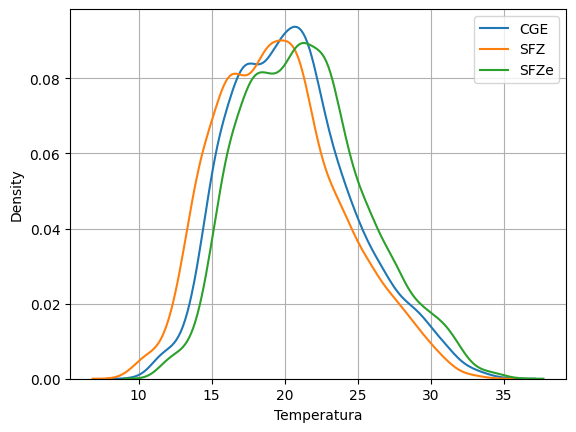

 
          sample_a     sample_b     sample_c
count  8087.000000  8087.000000  8087.000000
mean     78.739199    81.917655    70.317030
std      16.904725    16.164420    15.008270
min      17.407833    22.250833    18.827500
25%      68.467833    72.235000    60.766667
50%      84.335833    87.800000    75.033333
75%      91.759250    94.491667    81.758750
max      99.993000   100.000000    96.125000
 
Umidade relativa: CGE Sé X SFZ
Mann-Whitney: p-value: 7.600309879039853e-50. Samples are different, then reject null hypothesis (H0)
 
Umidade relativa: CGE Sé X SFZe
Mann-Whitney: p-value: 0.0. Samples are different, then reject null hypothesis (H0)


/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


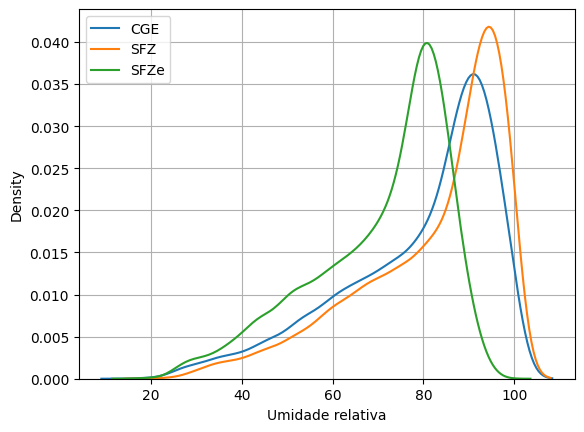

 
          sample_a     sample_b     sample_c
count  8028.000000  8028.000000  8028.000000
mean      0.233340    -1.532394     0.426562
std       0.531544     3.212829     0.333222
min      -1.983481    -8.919590    -0.501763
25%       0.000000    -3.939504     0.252020
50%       0.033627    -2.019903     0.408913
75%       0.436771     0.428470     0.577425
max       4.295853     9.271995    17.013821
 
Vel. do vento (zonal): CGE Sé X SFZ
Mann-Whitney: p-value: 0.0. Samples are different, then reject null hypothesis (H0)
 
Vel. do vento (zonal): CGE Sé X SFZe
Mann-Whitney: p-value: 0.0. Samples are different, then reject null hypothesis (H0)


/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


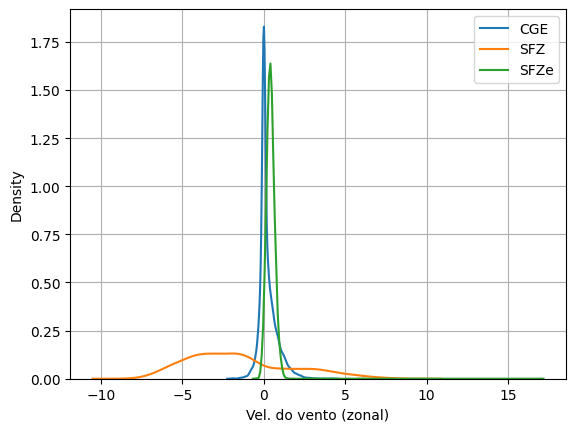

 
          sample_a     sample_b     sample_c
count  8028.000000  8028.000000  8028.000000
mean      0.041052     0.155116     1.058895
std       1.206997     2.223180     0.532452
min      -5.786345    -6.972439   -13.772254
25%      -0.358297    -1.453086     0.692604
50%       0.000000     0.274438     0.959891
75%       0.627698     1.742323     1.350964
max       5.079736     8.595673     5.628780
 
Vel. do vento (meridional): CGE Sé X SFZ
Mann-Whitney: p-value: 4.836824033942445e-08. Samples are different, then reject null hypothesis (H0)
 
Vel. do vento (meridional): CGE Sé X SFZe
Mann-Whitney: p-value: 0.0. Samples are different, then reject null hypothesis (H0)


/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


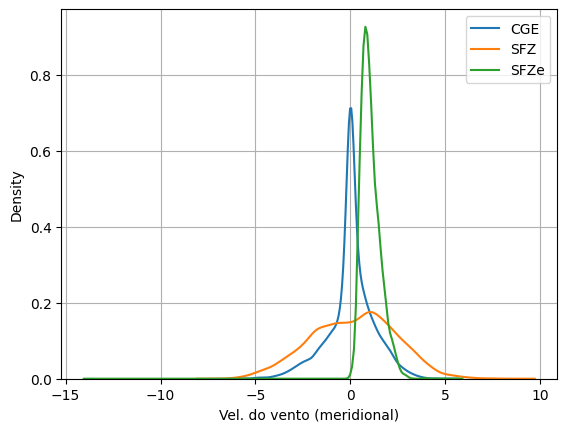

In [122]:
# urban
import seaborn as sns
import matplotlib.pyplot as plt

for i in ["Temperatura", "Umidade relativa", "Vel. do vento (zonal)", "Vel. do vento (meridional)"]:
    try:
        sample_A = cge_se[["timestamp", i]].rename(columns={i: "sample_a"})
        sample_A["timestamp"] = sample_A["timestamp"].astype(str)

        sample_B = SFZ_2017[[i]].rename(columns={i: "sample_b"})
        sample_B = sample_B.reset_index()
        sample_B["timestamp"] = sample_B["timestamp"].astype(str)

        sample_C = SFZe_2017[[i]].rename(columns={i: "sample_c"})
        sample_C = sample_C.reset_index()
        sample_C["timestamp"] = sample_C["timestamp"].astype(str)
        
        df = sample_A.merge(sample_B, on="timestamp").merge(sample_C, on="timestamp").dropna()
        
        # if i == "Umidade relativa":
        #     df = df[(df.sample_a > 0) & (df.sample_b > 0) & (df.sample_c > 0)]
        if i == "Vel. do vento (zonal)" or i == "Vel. do vento (meridional)":
            df = df[(df.sample_a < 20) & (df.sample_b < 20) & (df.sample_c < 20)]
        
        print(df.drop("timestamp", axis=1).describe())
        print(" ")
        print(f"{i}: CGE Sé X SFZ")
        print(statistical_test(sample_a=df.sample_a, sample_b=df.sample_b)[2])
        print(" ")
        print(f"{i}: CGE Sé X SFZe")
        print(statistical_test(sample_a=df.sample_a, sample_b=df.sample_c)[2])       
        
        sns.kdeplot(df["sample_a"], label="CGE")
        sns.kdeplot(df["sample_b"], label="SFZ")
        sns.kdeplot(df["sample_c"], label="SFZe")
        plt.xlabel(i)
        plt.legend()
        plt.grid()
        plt.savefig(f'../figures/analise_urbana_{i}.png', dpi=300, bbox_inches="tight")
        plt.show()

        print(" ")
    except:
        pass

In [123]:
df.drop("timestamp", axis=1).describe()

,sample_a,sample_b,sample_c
count,8028.000000,8028.000000,8028.000000
mean,0.041052,0.155116,1.058895
std,1.206997,2.223180,0.532452
min,-5.786345,-6.972439,-13.772254
25%,-0.358297,-1.453086,0.692604
50%,0.000000,0.274438,0.959891
75%,0.627698,1.742323,1.350964
max,5.079736,8.595673,5.628780


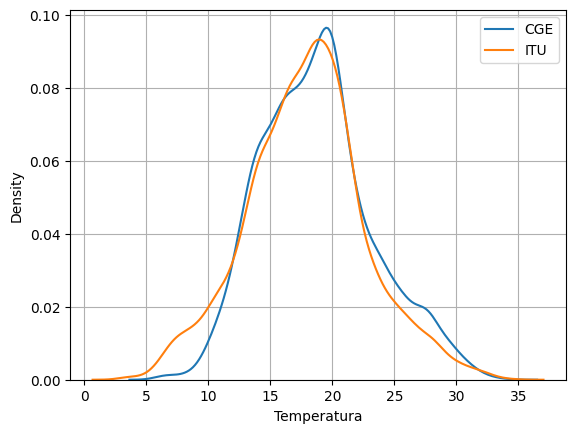

Temperatura: CGE Parelheiros X IAG Itutinga
          sample_a     sample_b
count  7564.000000  7564.000000
mean     18.742024    17.895757
std       4.530093     4.789574
min       5.908333     3.067083
25%      15.465625    14.809792
50%      18.551417    18.061667
75%      21.294875    20.727083
max      34.239333    34.628333
Mann-Whitney: p-value: 2.424654922290662e-19. Samples are different, then reject null hypothesis (H0)
 


/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


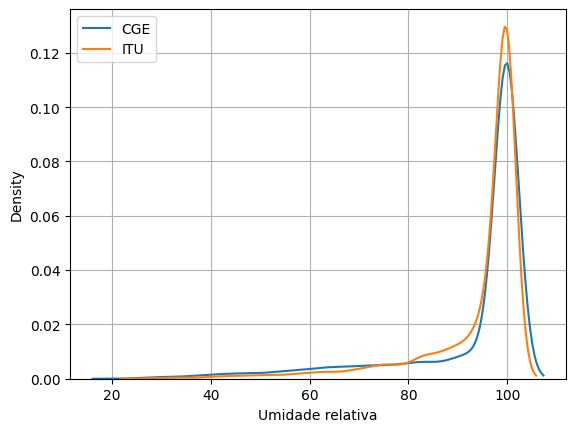

Umidade relativa: CGE Parelheiros X IAG Itutinga
          sample_a     sample_b
count  7638.000000  7638.000000
mean     92.709266    93.840923
std      14.618786    11.623721
min      23.383667    27.431667
25%      93.761583    93.539583
50%      99.993000    99.608333
75%      99.993000   100.000000
max      99.993000   100.000000
Mann-Whitney: p-value: 2.9264120163425156e-43. Samples are different, then reject null hypothesis (H0)
 


/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


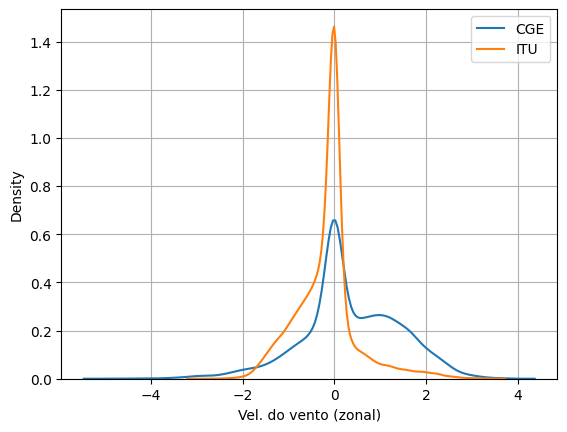

Vel. do vento (zonal): CGE Parelheiros X IAG Itutinga
          sample_a     sample_b
count  8167.000000  8167.000000
mean      0.348388    -0.157750
std       1.073187     0.669651
min      -4.932419    -2.881820
25%      -0.141284    -0.499443
50%       0.135108    -0.039879
75%       1.102762     0.014873
max       3.840774     3.393878
Mann-Whitney: p-value: 0.0. Samples are different, then reject null hypothesis (H0)
 


/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


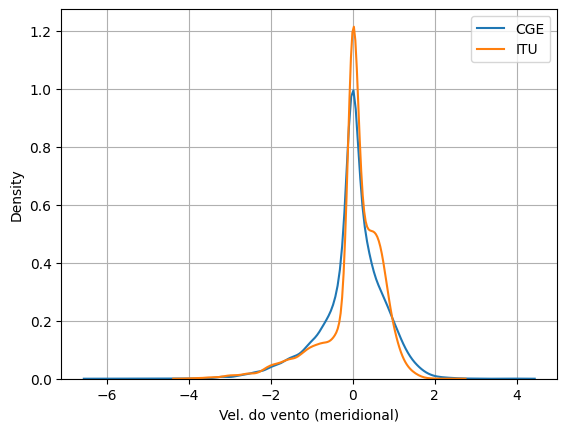

Vel. do vento (meridional): CGE Parelheiros X IAG Itutinga
          sample_a     sample_b
count  8167.000000  8167.000000
mean     -0.005807     0.016250
std       0.774154     0.737664
min      -6.170024    -4.007920
25%      -0.271174    -0.035346
50%       0.000000     0.034277
75%       0.414087     0.470306
max       4.058874     2.388766
Mann-Whitney: p-value: 4.34091247744925e-14. Samples are different, then reject null hypothesis (H0)
 


/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [124]:
# rural
for i in ["Temperatura", "Umidade relativa", "Vel. do vento (zonal)", "Vel. do vento (meridional)"]:
    try:
        sample_A = cge_parelheiros[["timestamp", i]].rename(columns={i: "sample_a"})
        sample_A["timestamp"] = sample_A["timestamp"].astype(str)

        sample_B = ITU_2017[[i]].rename(columns={i: "sample_b"})
        sample_B = sample_B.reset_index()
        sample_B["timestamp"] = sample_B["timestamp"].astype(str)

        df = sample_A.merge(sample_B, on="timestamp").dropna()
        df = df[(df.sample_a > -1000) & (df.sample_b > -1000)]

        sns.kdeplot(df["sample_a"], label="CGE")
        sns.kdeplot(df["sample_b"], label="ITU")
        plt.xlabel(i)
        plt.legend()
        plt.grid()
        plt.savefig(f'../figures/analise_rural_{i}.png', dpi=300, bbox_inches="tight")
        plt.show()

        print(f"{i}: CGE Parelheiros X IAG Itutinga")
        print(df.drop("timestamp", axis=1).describe())
        print(statistical_test(sample_a=df.sample_a, sample_b=df.sample_b)[2])

        print(" ")
    except:
        pass

In [125]:
cge_se.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8733 entries, 59862 to 68596
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   timestamp                   8733 non-null   object 
 1   Temperatura                 8733 non-null   float64
 2   precipitation               8733 non-null   float64
 3   Umidade relativa            8733 non-null   float64
 4   pressure                    8733 non-null   float64
 5   Vel. do vento (zonal)       8733 non-null   float64
 6   Vel. do vento (meridional)  8733 non-null   float64
dtypes: float64(6), object(1)
memory usage: 545.8+ KB


In [126]:
cge_uhii = cge_se[["timestamp", "Temperatura"]].rename(columns={"Temperatura": "Temp. Urbana"}).merge(
    cge_parelheiros[["timestamp", "Temperatura"]].rename(columns={"Temperatura": "Temp. Rural"}), 
    on="timestamp"
)

cge_uhii["IICU (CGE)"] = cge_uhii["Temp. Urbana"] - cge_uhii["Temp. Rural"]
cge_uhii

,timestamp,Temp. Urbana,Temp. Rural,IICU (CGE)
0,2017-01-01 01:00:00,24.189667,21.049167,3.140500
1,2017-01-01 02:00:00,23.773500,21.106167,2.667333
2,2017-01-01 03:00:00,24.005167,21.413167,2.592000
3,2017-01-01 04:00:00,23.988000,20.844333,3.143667
4,2017-01-01 05:00:00,23.627500,20.683167,2.944333
...,...,...,...,...
8728,2017-12-30 19:00:00,21.305833,20.386000,0.919833
8729,2017-12-30 20:00:00,21.490667,20.398000,1.092667
8730,2017-12-30 21:00:00,21.236833,20.458167,0.778667
8731,2017-12-30 22:00:00,21.225167,20.199667,1.025500


In [127]:
SFZe_2017 = SFZe_2017.reset_index()
SFZe_2017["timestamp"] = SFZe_2017["timestamp"].astype(str)

ITU_2017 = ITU_2017.reset_index()
ITU_2017["timestamp"] = ITU_2017["timestamp"].astype(str)

iag_uhii = SFZe_2017[["timestamp", "Temperatura"]].rename(columns={"Temperatura": "Temp. Urbana"}).merge(
    ITU_2017[["timestamp", "Temperatura"]].rename(columns={"Temperatura": "Temp. Rural"}), 
    on="timestamp"
)

iag_uhii["IICU (IAG)"] = iag_uhii["Temp. Urbana"] - iag_uhii["Temp. Rural"]
iag_uhii

,timestamp,Temp. Urbana,Temp. Rural,IICU (IAG)
0,2017-01-01 00:00:00,25.479333,20.287500,5.191833
1,2017-01-01 01:00:00,25.476250,20.059167,5.417083
2,2017-01-01 02:00:00,24.139750,19.351667,4.788083
3,2017-01-01 03:00:00,23.395167,19.265833,4.129333
4,2017-01-01 04:00:00,23.293333,19.806667,3.486667
...,...,...,...,...
8755,2017-12-31 19:00:00,23.035250,22.016667,1.018583
8756,2017-12-31 20:00:00,22.960500,21.051667,1.908833
8757,2017-12-31 21:00:00,22.707250,19.840000,2.867250
8758,2017-12-31 22:00:00,22.369667,19.417500,2.952167


In [128]:
uhii = cge_uhii[["timestamp", "IICU (CGE)"]].merge(iag_uhii[["timestamp", "IICU (IAG)"]], on="timestamp")
uhii

,timestamp,IICU (CGE),IICU (IAG)
0,2017-01-01 01:00:00,3.140500,5.417083
1,2017-01-01 02:00:00,2.667333,4.788083
2,2017-01-01 03:00:00,2.592000,4.129333
3,2017-01-01 04:00:00,3.143667,3.486667
4,2017-01-01 05:00:00,2.944333,3.902250
...,...,...,...
8728,2017-12-30 19:00:00,0.919833,2.295917
8729,2017-12-30 20:00:00,1.092667,2.369417
8730,2017-12-30 21:00:00,0.778667,3.020167
8731,2017-12-30 22:00:00,1.025500,3.530750


In [129]:
uhii.describe()

,IICU (CGE),IICU (IAG)
count,8733.000000,8164.000000
mean,2.083199,741.744684
std,1.730427,2615.444142
min,-6.611833,-6.073750
25%,0.990333,2.179500
50%,1.874833,3.190417
75%,2.909167,5.850938
max,12.428000,10028.579500


In [130]:
uhii = uhii[uhii["IICU (IAG)"] < 50]

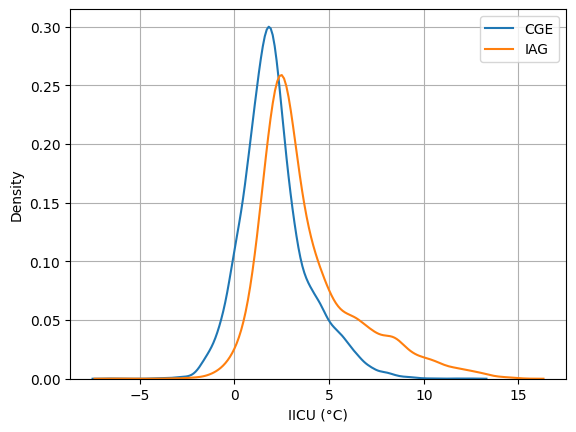

Vel. do vento (meridional): CGE X IAG
        IICU (CGE)   IICU (IAG)
count  7561.000000  7561.000000
mean      2.108020     3.810482
std       1.757231     2.623856
min      -6.611833    -6.073750
25%       1.014167     2.098583
50%       1.901667     2.991583
75%       2.932667     4.880333
max      12.428000    15.005167
Mann-Whitney: p-value: 0.0. Samples are different, then reject null hypothesis (H0)


/home/ubuntu/ml-uhi/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [131]:
# UHII analysis
sns.kdeplot(uhii["IICU (CGE)"], label="CGE")
sns.kdeplot(uhii["IICU (IAG)"], label="IAG")
plt.xlabel("IICU (°C)")
plt.legend()
plt.grid()
plt.savefig(f'../figures/analise_iicu_{i}.png', dpi=300, bbox_inches="tight")
plt.show()

print(f"{i}: CGE X IAG")
print(uhii.drop("timestamp", axis=1).describe())
print(statistical_test(sample_a=uhii["IICU (CGE)"], sample_b=uhii["IICU (IAG)"])[2])

In [132]:
# # feature engineering on IAG urban and rural data
# def feature_eng(df):
#     df["timestamp"] = pd.to_datetime(df["timestamp"])
#     df = df.set_index("timestamp")
#     to_drop = ["station", "station_name"]
#     cols = list(df.drop(to_drop, axis=1).columns)
#     df = feature_engineer(df=df, features=cols, lags=12, window=12)
#     cols.remove("temperature")
#     df = df.drop(cols, axis=1)
#     return df

# SFZe_2017_processed = feature_eng(SFZe_2017)
# ITU_2017_processed = feature_eng(ITU_2017)

In [133]:
# SFZe_2017_processed

In [134]:
# ITU_2017_processed

In [135]:
# def make_steps(
#     df : pd.DataFrame, 
#     y : str, 
#     steps : int
#     ) -> pd.DataFrame:
#     """
#     Get target feature steps ahead.

#     Parameters
#     ----------
#     df : pandas data frame
#         Data frame with target feature.
    
#     y : str
#         Target feature name.
    
#     steps : int
#         Steps to forecast.

#     Returns
#     -------
#     df : pandas data frame
#         Data frame with target features.
#     """

#     for i in range(steps):
#         df[f"{y}_step_{i+1}"] = df[y].shift(-i+1)
#     return df


# # models
# rid = RegressorChain(
#     base_estimator=RidgeCV(
#         alphas=[1e-3, 1e-2, 1e-1, 1],
#         cv=TimeSeriesSplit(n_splits=3, test_size=2000),
#     ),
#     random_state=123
# )

# gb = RegressorChain(
#     base_estimator=HalvingGridSearchCV(
#         estimator=HistGradientBoostingRegressor(random_state=123),
#         param_grid = {
#             "max_depth": np.arange(10, 40, 10, dtype=int),
#             "learning_rate": np.logspace(-3, -1, 3)
#         },
#         cv=TimeSeriesSplit(n_splits=3, test_size=2000),
#         aggressive_elimination=True,
#         scoring="neg_mean_squared_error",
#         random_state=123,
#         n_jobs=-1
#     ),
#     random_state=123
# )

# mlp = RegressorChain(
#     base_estimator=HalvingGridSearchCV(
#         estimator=MLPRegressor(max_iter=500, random_state=123),
#         param_grid = {
#             "hidden_layer_sizes": [(100,), (100, 75, 25)],
#             "activation": ["identity", "logistic", "tanh", "relu"]
#         },
#         cv=TimeSeriesSplit(n_splits=3, test_size=2000),
#         aggressive_elimination=True,
#         scoring="neg_mean_squared_error",
#         random_state=123,
#         n_jobs=-1
#     ),
#     random_state=123
# )

# models = {
#     "rid": rid,
#     "mlp": mlp,
#     "gb": gb,
# }

# def ml_pred(df):
#     df = df.dropna(axis=1, how="all")
#     df = df.dropna()

#     station = df.station.unique()[0]
#     station_name = df.station_name.unique()[0]
#     station_name_df = station_name.lower().replace(" ", "_")

#     df = df.reset_index()
#     ts = df[["timestamp"]]
#     df = df.drop(["station", "station_name", "timestamp"], axis=1)

#     # target
#     y = make_steps(df=df[["temperature"]], y="temperature", steps=6).drop("temperature", axis=1)
#     y = y.dropna()

#     # predictors
#     X = df.drop(["temperature"], axis=1)
#     X = X.loc[y.index.min():y.index.max()]

#     # scaling data
#     scaler = StandardScaler()
#     scaler.fit(X)
#     X_standard = scaler.transform(X)

#     # train and test data split
#     test_size = 0.30
#     X_train_ref, X_test_ref, _, _ = train_test_split(X, y, test_size=0.30, shuffle=False)
#     X_train, X_test, y_train, y_test = train_test_split(X_standard, y, test_size=test_size, shuffle=False)

#     # model training
#     preds = {}
#     for model in models:
#         models[model].fit(X_train, y_train)
#         y_pred = pd.DataFrame(models[model].predict(X_test), index=X_test_ref.index, columns=y.columns)
#         ts = ts.loc[y_pred.index.min():y_pred.index.max()]
#         y_pred["timestamp"] = ts.timestamp 
#         y_pred["station"] = station
#         y_pred["station_name"] = station_name
#         preds[f"{station_name_df}_{model}"] = y_pred
    
#     return preds

In [136]:
# preds_urban = ml_pred(SFZe_2017_processed)

In [137]:
# preds_rural = ml_pred(ITU_2017_processed)

In [138]:
# list(preds_urban.keys())

In [139]:
# preds_urban["secretaria_da_fazenda_rid"]

In [140]:
# model_name = {
#     "rid": "Ridge",
#     "mlp": "Multi-layer Perceptron",
#     "gb": "Histogram-based Gradient Boosting Regression Tree",
# }

# # getting evaluation metric from predictions
# performance_temp = []
# for pred_model in list(preds_urban.keys()):
#     y_true = SFZe_2017_processed.reset_index()[["timestamp", "temperature"]].dropna()
#     y_true["timestamp"] = pd.to_datetime(y_true["timestamp"])
#     y_true = y_true.set_index("timestamp")

#     y_pred = preds_urban[pred_model]
#     y_pred = y_pred.drop(["station", "station_name"], axis=1)
#     y_pred["timestamp"] = pd.to_datetime(y_pred["timestamp"])

#     # y_true_rural = pd.read_csv(io.BytesIO(obj_true_rural["Body"].read()))
#     # y_true_rural = y_true_rural[["timestamp", "temperature"]].dropna()
#     # y_true_rural["timestamp"] = pd.to_datetime(y_true_rural["timestamp"])
#     # y_true_rural = y_true_rural.set_index("timestamp")

#     # y_pred_rural = pd.read_csv(io.BytesIO(obj_pred_rural["Body"].read()), index_col=0)
#     # y_pred_rural = y_pred_rural.drop(["station", "station_name"], axis=1)
#     # y_pred_rural["timestamp"] = pd.to_datetime(y_pred_rural["timestamp"])

#     mse_temperature = []
#     mse_uhi = []
#     for i in y_pred.index:
#         try:
#             pred = y_pred.loc[[i]]
#             start_date = pred.timestamp.unique()[0] + np.timedelta64(1, "h")
#             pred = pred.drop("timestamp", axis=1).T
#             pred.index = pd.date_range(start=start_date, periods=6, freq="H")
#             pred.columns = ["temperature"]

#             # pred_rural = y_pred_rural[y_pred_rural.timestamp == start_date]
#             # pred_rural = pred_rural.drop("timestamp", axis=1).T
#             # pred_rural.index = pd.date_range(start=start_date, periods=6, freq="H")
#             # pred_rural.columns = ["temperature_rural"]

#             # pred_uhii = pred.merge(pred_rural, left_index=True, right_index=True)
#             # pred_uhii["uhii"] = pred_uhii.temperature - pred_uhii.temperature_rural
#             # pred_uhii = pred_uhii.drop(["temperature", "temperature_rural"], axis=1)

#             test_plot = y_true[pred.index[0]:pred.index[-1]]
#             # test_plot_rural = y_true_rural[pred.index[0]:pred.index[-1]]
#             # test_plot_rural.columns = ["temperature_rural"]
#             # test_plot_uhii = test_plot.merge(test_plot_rural, left_index=True, right_index=True)
#             # test_plot_uhii["uhii"] = test_plot_uhii.temperature - test_plot_uhii.temperature_rural
#             # test_plot_uhii = test_plot_uhii.drop(["temperature", "temperature_rural"], axis=1)

#             try:
#                 mse_temperature.append(mean_squared_error(test_plot, pred))
#                 # mse_uhi.append(mean_squared_error(test_plot_uhii, pred_uhii))
#             except:
#                 pass
#         except:
#             pass

#     # temperature evaluation
#     model_error_temperature = pd.DataFrame({
#         "Station": ["SFZe"],
#         "Model": [pred_model],
#         "MSE": [np.round(np.mean(mse_temperature), 2)],
#         "MSE standard deviation": [np.round(np.std(mse_temperature), 2)]
#         })
    
#     performance_temp.append(model_error_temperature)

#     # # UHI evaluation        
#     # model_error_uhi = pd.DataFrame({
#     #     "Station": [station_name],
#     #     "Model": [pred_model],
#     #     "MSE": [np.round(np.mean(mse_temperature), 2)],
#     #     "MSE standard deviation": [np.round(np.std(mse_temperature), 2)]
#     #     })


In [141]:
# pd.concat(performance_temp)